# Optimization of wind farm including neighbouring turbines
In Topfarm you have the option to include neighbouring wind turbines in your optimization. This means that the wakes from these turbines will be considered when calulating the optimal AEP, but their positions are not considered design variables. Note that the accuaracy of this is dependent on the distance to the neighbouring wind turbines and your wind farm models ability to predict long distance wakes.

In [0]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import topfarm
from topfarm import TopFarmProblem
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponentAdditionalTurbines
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.plotting import XYPlotComp
from topfarm.cost_models.cost_model_wrappers import AEPCostModelComponent

from py_wake.deficit_models.gaussian import BastankhahGaussian
from py_wake.utils.gradients import autograd
from py_wake.validation.lillgrund import wt_x, wt_y, LillgrundSite, ct_curve, power_curve
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


c:\sandbox\repo\topfarm\pywake\py_wake\deficit_models\gaussian.py:127: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')


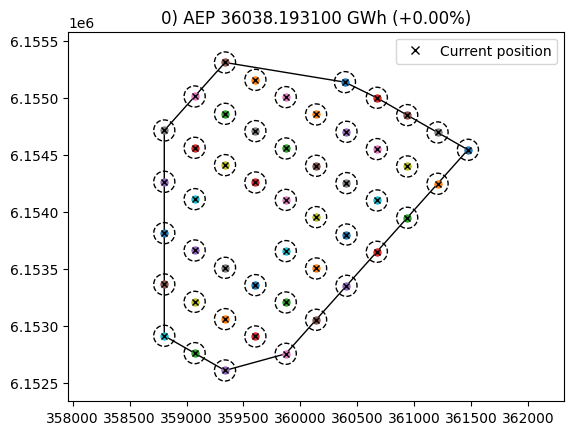

Iteration limit reached    (Exit mode 9)
            Current function value: -36307.44846200584
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimized in	102.574s


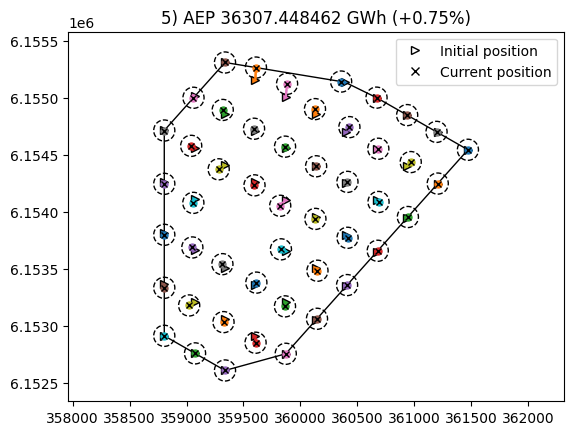

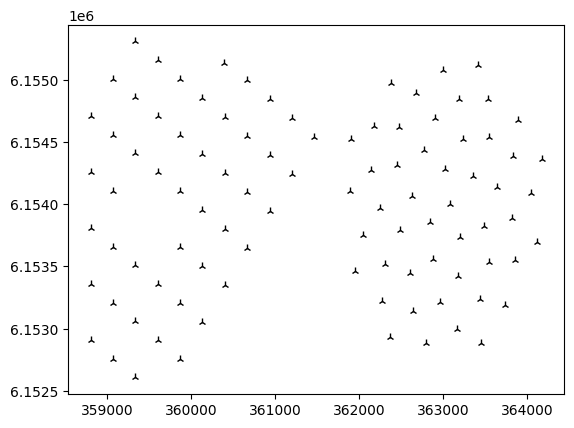

In [4]:
x2 = np.array([363089.20620581, 362841.19815026, 363024.53745529, 363202.56273871,
       362627.89297065, 363352.67353534, 362882.00280241, 362774.92495544,
       363488.38307778, 362491.87485306, 363244.96531305, 363181.03168444,
       362454.34857131, 363640.1295227 , 362609.32998744, 362909.74450436,
       363554.08869674, 362254.36079251, 363543.89240439, 362963.61115875,
       362482.47585633, 363819.8209275 , 362305.36330315, 363189.81567612,
       363439.03577114, 362141.72363739, 363833.70922823, 362638.81518275,
       362677.64959042, 363857.74204276, 362047.26220207, 363541.54387668,
       363172.26863347, 362183.59639605, 364044.33022603, 362278.14662334,
       363005.25808714, 363734.05077116, 361897.72732477, 363893.16789162,
       362796.78418716, 362387.86536213, 364121.72384201, 361953.11392421,
       363413.71283633, 363453.74796523, 361900.61873674, 364175.02685267,
       362371.77324208])
y2 = np.array([6154000.        , 6153854.5244973 , 6154279.59164709,
       6153735.79277733, 6154065.82049407, 6154224.34203495,
       6153561.05630649, 6154433.36830217, 6153821.6432833 ,
       6153790.2533259 , 6154523.47664532, 6153422.84246344,
       6154316.21615621, 6154140.73067986, 6153444.31210837,
       6154696.49543065, 6153533.01345979, 6153969.1654778 ,
       6154541.2455867 , 6153213.05775872, 6154620.16688662,
       6153889.69425372, 6153516.6898791 , 6154843.74971121,
       6153233.82403924, 6154273.81356891, 6154385.19480965,
       6153136.96734381, 6154896.21625677, 6153549.19482153,
       6153748.86137406, 6154842.22515422, 6152997.6181212 ,
       6154632.26883894, 6154086.52062451, 6153219.69765135,
       6155077.84457572, 6153190.81616147, 6154102.15838379,
       6154677.88258593, 6152882.94617467, 6154972.74316899,
       6153692.58200013, 6153462.7553504 , 6155115.91934059,
       6152885.37941837, 6154521.01729715, 6154362.27333719,
       6152928.04241305])
wind_turbines = WindTurbine('SWT2p3_93_65', 92.6, 65, PowerCtTabular(ct_curve[:,0],power_curve[:,1], 'kW', ct_curve[:,1]))
n_wt = len(wt_x)
site = LillgrundSite()
wf_model = BastankhahGaussian(site, wind_turbines)
constraint_comp = XYBoundaryConstraint(np.asarray([wt_x, wt_y]).T)
cost_comp = PyWakeAEPCostModelComponentAdditionalTurbines(windFarmModel=wf_model,
                                        n_wt=n_wt,
                                        add_wt_x=x2,
                                        add_wt_y=y2,
                                        grad_method=autograd)
plot_comp = XYPlotComp()
problem = TopFarmProblem(design_vars={'x': wt_x, 'y': wt_y},
                        constraints=[constraint_comp, SpacingConstraint(min_spacing=wind_turbines.diameter() * 2)],
                        cost_comp=cost_comp,
                        driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=5),
                        plot_comp=plot_comp)

cost, state, recorder = problem.optimize(disp=True)
plt.figure()
plt.plot(np.concatenate((wt_x, x2)), np.concatenate((wt_y, y2)), '2k')
